In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from scipy.stats import maxwell
from scipy.stats import norm

In [32]:
#####  Function to compute time for wall collision ######
def wall_time(coord, velcomp, rad):  
    if velcomp > 0.0:
        del_t = (1.0 - rad - coord) / velcomp
    elif velcomp < 0.0:
        del_t = (coord - rad) / abs(velcomp)
    else:
        del_t = float('inf')
    return del_t


# Function to calculate time it takes for a pair of particles to collide. 
# pos1 and pos2 are positions of particles 1 and 2, vel1 and vel2 are their 
# velocities. rad is the radius of the particles. 
def pair_time(pos1, vel1, pos2, vel2, rad):  
    rel_pos = pos2 - pos1
    rel_vel = vel2 - vel1
    rel_dist_squar = np.dot(rel_pos,rel_pos)
    rel_speed_squar = np.dot(rel_vel,rel_vel)
    scal_prod = np.dot(rel_pos,rel_vel)
    a = scal_prod ** 2 - rel_speed_squar * ( rel_dist_squar - 4.0 * rad **2)
    if a > 0.0 and scal_prod < 0.0: ## Conditions for collision.
        del_t = - (scal_prod + np.sqrt(a)) / rel_speed_squar ## Collision time.
    else:
        del_t = float('inf')
    return del_t


# Function to generate an image of the disk configuration in the box.
def create_picture(positions):
    plt.cla()
    plt.gca().set_aspect('equal')
    plt.axis([0, L, 0, L])
    plt.setp(plt.gca(), xticks=[0, L], yticks=[0, L])
    for x,y in positions:
        atom = plt.Circle((x, y), Ratom, fc='r')
        plt.gca().add_patch(atom)
      

0.063078313050504
[[0.12615663 0.12615663]
 [0.31539157 0.12615663]
 [0.5046265  0.12615663]
 [0.69386144 0.12615663]
 [0.12615663 0.31539157]
 [0.31539157 0.31539157]
 [0.5046265  0.31539157]
 [0.69386144 0.31539157]
 [0.12615663 0.5046265 ]
 [0.31539157 0.5046265 ]
 [0.5046265  0.5046265 ]
 [0.69386144 0.5046265 ]
 [0.12615663 0.69386144]
 [0.31539157 0.69386144]
 [0.5046265  0.69386144]
 [0.69386144 0.69386144]]
[[ 0.96383512  0.62796873]
 [-0.71674846 -0.8007346 ]
 [ 0.4679767   0.61974464]
 [-0.71155913 -0.49231024]
 [ 0.97369212  0.77518559]
 [-0.33366888 -0.85290724]
 [ 0.95139949  0.10230629]
 [-0.73031449 -0.34195498]
 [ 0.45565629  0.50471491]
 [-0.13108854 -0.35361199]
 [ 0.98401896  0.7566717 ]
 [-0.33130386 -0.38594092]
 [ 0.64967579  0.11502004]
 [-0.23357754 -0.46563489]
 [ 0.08446255  0.62595476]
 [-0.32367751 -0.14346421]]


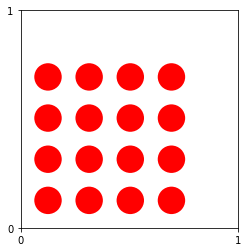

In [33]:
L = 1. ## Box edge length
N_s=4
Natoms = int((N_s)**2) # Number of disks
density = 0.2 # Fraction of the area of the box covered by the disks
Ratom = np.sqrt(density/(Natoms*np.pi))   ## Radius of disk.
print(Ratom)


## List indexing all pairs of atoms.
pairs = [[i,j] for i in range(Natoms) for j in range(i+1, Natoms)] 

## Positions and velocities of disks.
positions = np.zeros((Natoms,2))
velocities = np.zeros((Natoms,2))

for i in range (0,Natoms):
        positions[i][0]=Ratom*(3*(i%N_s)+2)
        positions[i][1]=Ratom*(3*(i//N_s)+2)
        velocities[i][0]=((-1)**i)*random.random()
        velocities[i][1]=((-1)**(i%2))*random.random()
print(positions)
print(velocities)
n_events = 20000 # Number of collision events.
create_picture(positions)
#################################################################################

In [34]:
 ############### Event Loop ##############################################
t = 0.0 # Initial time
def event_loop(positions,velocities,t):
     # Wall collision times for all disks and their velocity components.
    wall_times = [wall_time(positions[i][j], velocities[i][j], Ratom) for i in range(Natoms) for j in range(2)] 
    # Pair collision times
    pair_times = [pair_time(positions[i], velocities[i], positions[j], velocities[j], Ratom) for i,j in pairs] 
    # The next collision event is the minimum of wall and pair collision times.
    next_event = min(wall_times + pair_times)  
    t += next_event 
    #print(t)
    for i in range(Natoms):
        positions[i] += velocities[i]*next_event # Evolve positions to collision event
    if min(wall_times) < min(pair_times): # Check if next event is a collision with a wall
        wall_index = wall_times.index(next_event)
        particle, component = divmod(wall_index, 2)
        velocities[particle][component] *= -1.0 ## Velocity component normal to wall changes sign
    else:
        pair_index = pair_times.index(next_event)
        particle_1, particle_2 = pairs[pair_index] # Indices of particles participating in collision.
        rel_pos = positions[particle_2] - positions[particle_1]
        rel_vel = velocities[particle_2] - velocities[particle_1]
        distance = np.sqrt(np.dot(rel_pos,rel_pos))
        unit_perp = rel_pos/distance
        scal_prod = np.dot(rel_vel,unit_perp)
        velocities[particle_1] += scal_prod*unit_perp # Change in velocities of atoms colliding with each other
        velocities[particle_2] -= scal_prod*unit_perp
    return positions,velocities,t
V_array=[]
P_array=[]
for event in range(n_events):
    positions,velocities,t=event_loop(positions,velocities,t)
    if(event>5000):
        for h in range (0,Natoms):
            V_array.append(np.sqrt(np.dot(velocities[h],velocities[h])))
            P_array.append(np.sqrt(np.dot(positions[h],positions[h])))
print(positions)
print(velocities)
#print(V_array)
##################################################################################

[[0.54003992 0.67670148]
 [0.62401163 0.83959658]
 [0.86029568 0.0866553 ]
 [0.91372691 0.38520108]
 [0.59747199 0.42232808]
 [0.75181434 0.33348294]
 [0.67355286 0.6773059 ]
 [0.45834626 0.8113321 ]
 [0.20349804 0.72628337]
 [0.39482148 0.41049274]
 [0.24299705 0.25676731]
 [0.90506727 0.56672059]
 [0.79751354 0.5007836 ]
 [0.15097866 0.40065033]
 [0.4260455  0.57181428]
 [0.83641424 0.85894471]]
[[ 0.79109196  0.40347446]
 [ 0.72495218 -0.63248975]
 [-0.04235697  0.81920872]
 [ 0.27679946 -0.21625704]
 [-0.78145723  0.72590106]
 [-0.24816218  0.31957956]
 [ 0.38694358 -0.11774468]
 [ 1.13973311  0.87378245]
 [ 0.49561184  0.41096446]
 [ 1.39324376  0.47282893]
 [-0.10980351 -1.07531355]
 [ 0.47204198  0.31152572]
 [-0.7330427  -0.38932225]
 [ 0.11629873  0.11728185]
 [ 0.50147857 -0.46683767]
 [-0.34826417  0.081034  ]]


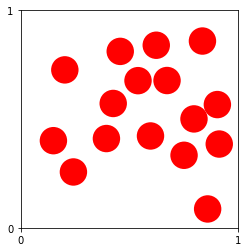

In [35]:
create_picture(positions)

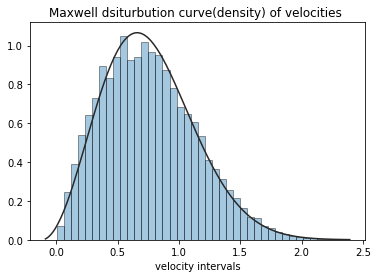

In [36]:
#plt.hist(V_array, bins=20, density=True)
sns.distplot(V_array,bins=40, hist_kws={'edgecolor':'black'}, fit=maxwell ,axlabel="velocity intervals",kde=False)
plt.title("Maxwell dsiturbution curve(density) of velocities ")
plt.show()

In [37]:
##https://indianaiproduction.com/seaborn-histogram-using-seaborn-distplot/  -- link for histogram commands

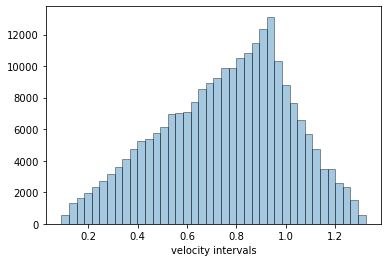

In [38]:
sns.distplot(P_array,bins=40, hist_kws={'edgecolor':'black'} ,axlabel="velocity intervals",kde=False)  ## this plot is wrong